In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from netCDF4 import Dataset,date2num, num2date
import os
import netCDF4
import cartopy.crs as ccrs
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor, Ridge
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
%matplotlib inline

import statsmodels.api as sm
import statsmodels as sm

In [2]:
import sys

HOME = "/scistor/ivm/the410"

sys.path.append(f'{HOME}/CirculationTrends_Happe2025JCLi/')

from GolfVijf.thresholding import *
from GolfVijf.utils import plot_trends_per_gridpoint, onelag_cov, covariance_timeseries, xr_linregress, trendfit_robust, data_for_pcolormesh, covariance_timeseries2
from GolfVijf.processing import load_and_subset_data, compute_trend_pattern, remove_spatmean_variability, spatial_subset, subdomains

from compositing import _significance_t_test, get_stream_trend_pattern_CMIP6_plus_covar 

#from Tamara_notebooks.data_loading import * 
#from Tamara_notebooks.DDdays_processing import create_event_length_per_year

# Load Streamfunction data and calculate trend

In [6]:
path_data='/scistor/ivm/the410/WAVE5'

In [7]:
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"

lower_year=1979
upper_year=2014


In [8]:
import warnings
warnings.filterwarnings("ignore")

daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
daJJA.attrs["long_name"]= longname

daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)
daJJA_removed_seasonality.attrs["units"]=unit

daJJA_all = compute_trend_pattern(daJJA_removed_seasonality)

In [9]:
daJJA_1979_2015 = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year>=lower_year)
daJJA_1979_2015 = daJJA_1979_2015.sel(time=daJJA_1979_2015.time.dt.year<=upper_year)
daJJA_1979_2015.attrs["units"]=unit

daJJA_1979_2015_trend = compute_trend_pattern(daJJA_1979_2015)

## plotting trends - Figure B8

In [7]:
# Determining locations and consistent color coding
sf_extreme_locs =[(58,-150),(42,-125),(41,-86),(56,-60),(52,-20),(47,3),(52,30),(39.5,65),(45,100),(38,177)] # lat, lon
geocolor = ['orange'] * 4 + ['green'] * 5 + ['black'] # us, europe, other
geosty = ['solid','dotted','dashed','dashdot','solid','dotted','dashed','dashdot',(0,(5,1)),'solid']
geoclass = {loc:{'color':color,'linestyle':sty} for loc, color, sty in zip(sf_extreme_locs, geocolor, geosty)}

# This is the indicator dictionary that says for the entire notebook whether to look at highs or lows
sf_extreme_positive = {(lat,lon) : bool(daJJA_all.sel(latitude = lat, longitude = lon, method = 'nearest') > 60000) for lat, lon in sf_extreme_locs}

In [8]:
subdomains

{'midlat': (35, 70, None, None),
 'noratl': (35, 70, -60, 60),
 'noramer': (35, 70, -170, -60),
 'europe': (35, 70, -15, 43),
 'ned': (50, 54, -2, 3),
 'circumglobal': (35, 70, -180, 180),
 'Both': (35, 70, -100, 110),
 'US_Atl': (35, 70, -100, 0),
 'EURASIA': (35, 70, 15, 110),
 'tropics': (-20, 30, -180, 180),
 'nhext': (-20, 90, -180, 180)}

In [9]:
subdomains_ = {
             'circumglobal': (35,70,-180,180),
        'Both': (35,70,-100,110),
'US_Atl':(35,70,-100,0),
        'EURASIA': (35,70,15,110)}

colors_dict  = {'US_Atl':'lawngreen',
        'EURASIA': 'yellow',
             'Both': 'blue',
             'circumglobal': 'black'}

circumglobal (35, 70, -180, 180)
Both (35, 70, -100, 110)
US_Atl (35, 70, -100, 0)
EURASIA (35, 70, 15, 110)


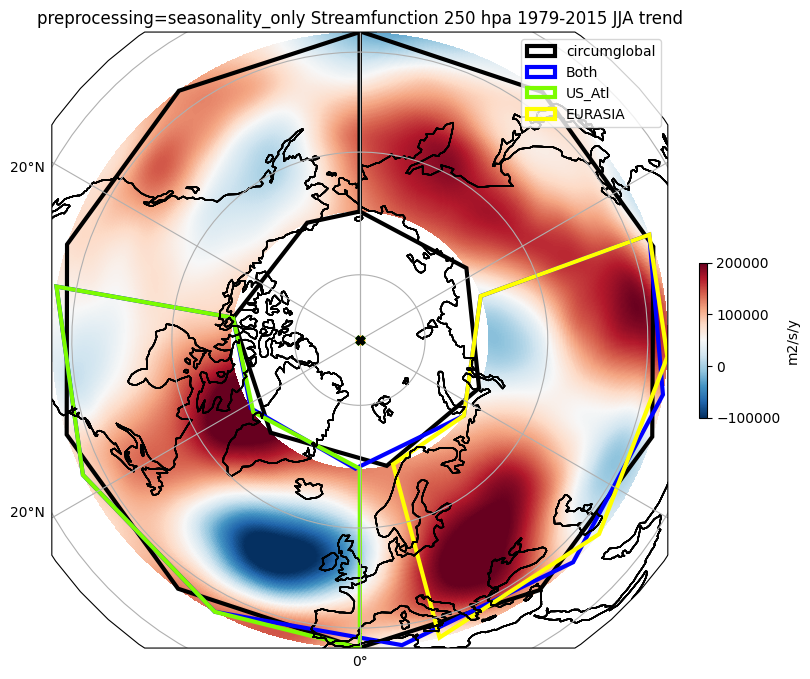

In [13]:
# plot polar projection LambertConformal(central_longitude=-96.0

# data=daJJA_1979_None_trend
# year_str="1979-2023"

data=daJJA_1979_2015_trend
year_str="1979-2015"

######
shading = 'flat'
vmin, vmax = -100000, 200000
cmap = 'RdBu_r'
fig, ax = plt.subplots(figsize = (20,8), subplot_kw={'projection':ccrs.Orthographic(central_longitude=0,central_latitude=90)}) #subplot_kw={'projection':ccrs.LambertConformal()}
im = ax.pcolormesh(data.longitude, data.latitude, data.values[:-1,:-1], transform=ccrs.PlateCarree(),
                        shading = shading, cmap = cmap, vmin = vmin, vmax = vmax)

for lat, lon in sf_extreme_locs:
    marker = 'o' if sf_extreme_positive[(lat,lon)] else 'X'
    ax.scatter(lon, lat, color = geoclass[(lat,lon)]['color'],zorder = 10, marker = marker)
    ax.coastlines()

for subdomain, coords in subdomains_.items():
    print(subdomain, coords)
    ax.add_patch(mpatches.Rectangle(xy=[coords[2], coords[0]], width=coords[3]-coords[2], height=coords[1]-coords[0],
                                        facecolor='none', edgecolor=colors_dict[subdomain], linewidth=3,
                                        transform=ccrs.PlateCarree(), label=subdomain))
    
plt.legend()    
ax.set_title(f'preprocessing={preprocessing} {longname} {year_str} JJA trend')
ax.gridlines(draw_labels = ['left','bottom'])
fig.colorbar(im, ax=ax, fraction=0.005, pad=0.02, label=f"{unit}/y")
plt.show()

## To get the CMIP6 trend from a model, and the covariance (pattern correlation) between the model and ERA5

do this for all the models, we save the trends and covar information

In [3]:
cmip6_names = ['ACCESS-CM2',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2-WACCM',
 'CMCC-CM2-HR4',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'GFDL-CM4',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'IPSL-CM6A-LR-INCA',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

In [4]:
#to save the trends
cmip6_trends = np.zeros((33,141,1440))
#to save the covars:
cmip6_covars_trend_nonmasked = {}


ACCESS-CM2
1979-2014
ACCESS-CM2
variable of interest is stream
trend plot doesn't exists yet
AWI-ESM-1-1-LR
1979-2014
AWI-ESM-1-1-LR
variable of interest is stream
trend plot doesn't exists yet
BCC-CSM2-MR
1979-2014
BCC-CSM2-MR
variable of interest is stream
converting calendar
trend plot doesn't exists yet
CAMS-CSM1-0
1979-2014
CAMS-CSM1-0
variable of interest is stream
trend plot doesn't exists yet
CESM2-WACCM
1979-2014
CESM2-WACCM
variable of interest is stream
converting calendar
trend plot doesn't exists yet
CMCC-CM2-HR4
1979-2014
CMCC-CM2-HR4
variable of interest is stream
converting calendar
trend plot doesn't exists yet
CMCC-CM2-SR5
1979-2014
CMCC-CM2-SR5
variable of interest is stream
converting calendar
trend plot doesn't exists yet
CMCC-ESM2
1979-2014
CMCC-ESM2
variable of interest is stream
converting calendar
trend plot doesn't exists yet
CNRM-CM6-1
1979-2014
CNRM-CM6-1
variable of interest is stream
trend plot doesn't exists yet
CNRM-ESM2-1
1979-2014
CNRM-ESM2-1
variable 

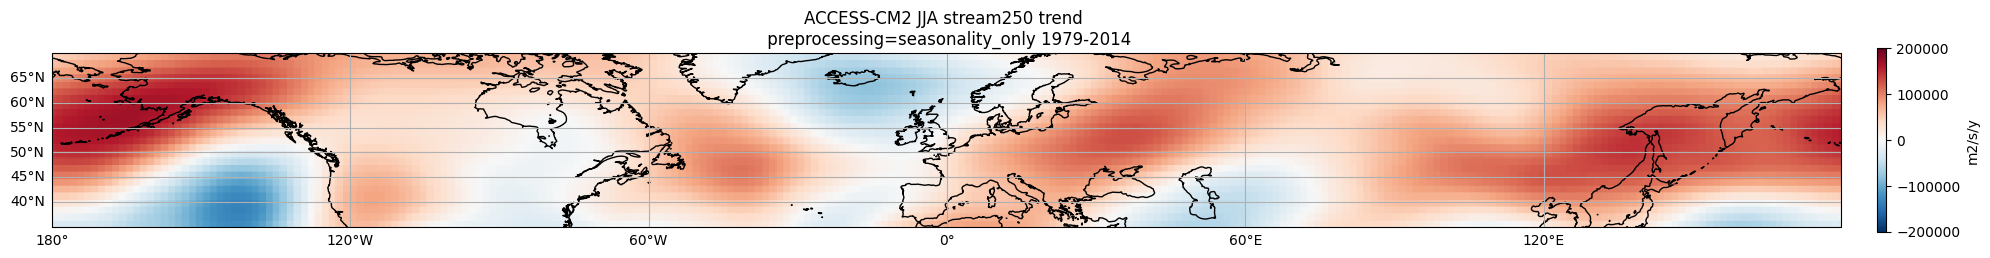

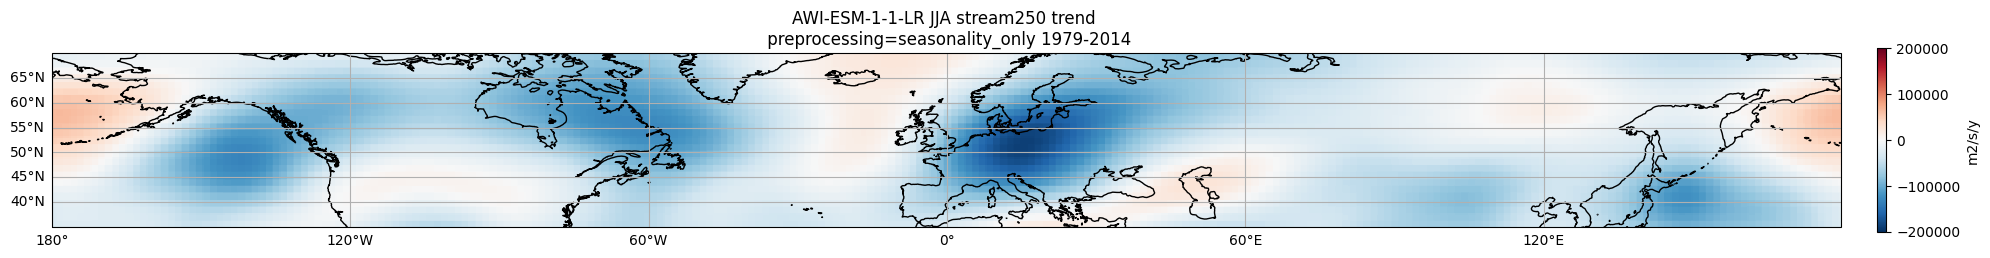

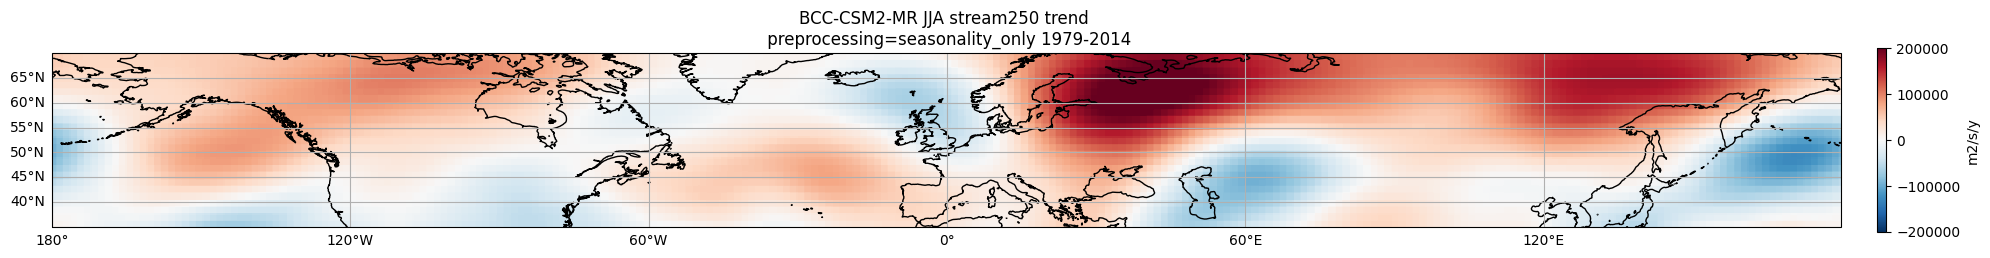

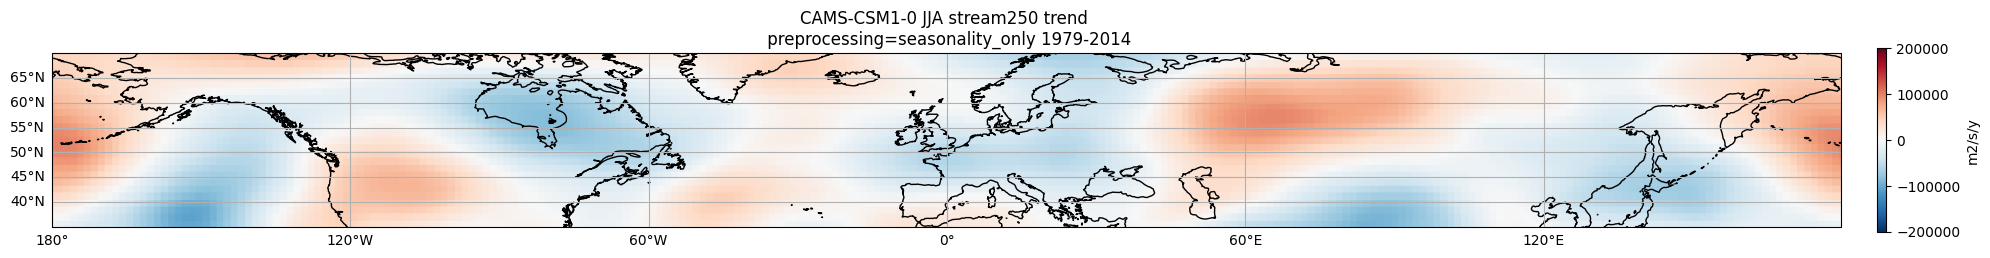

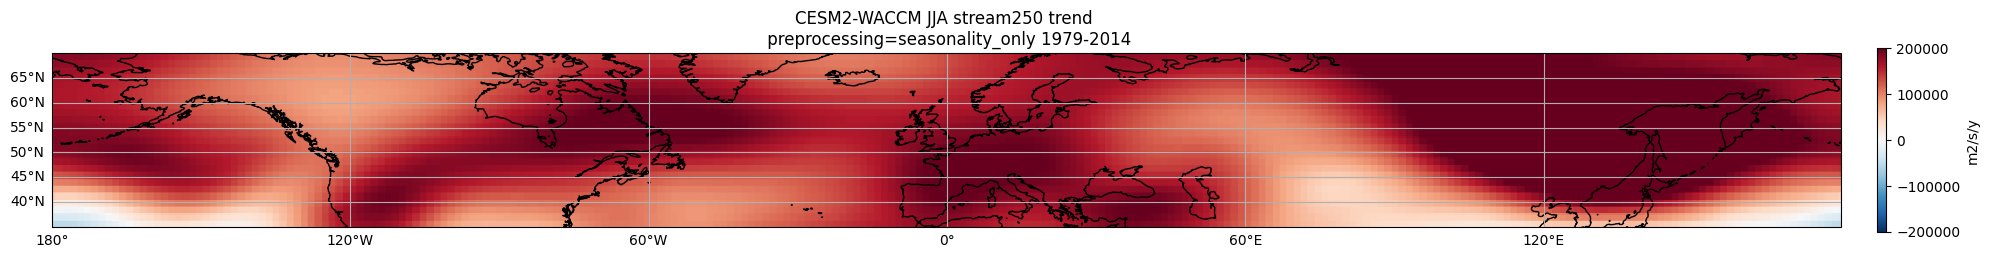

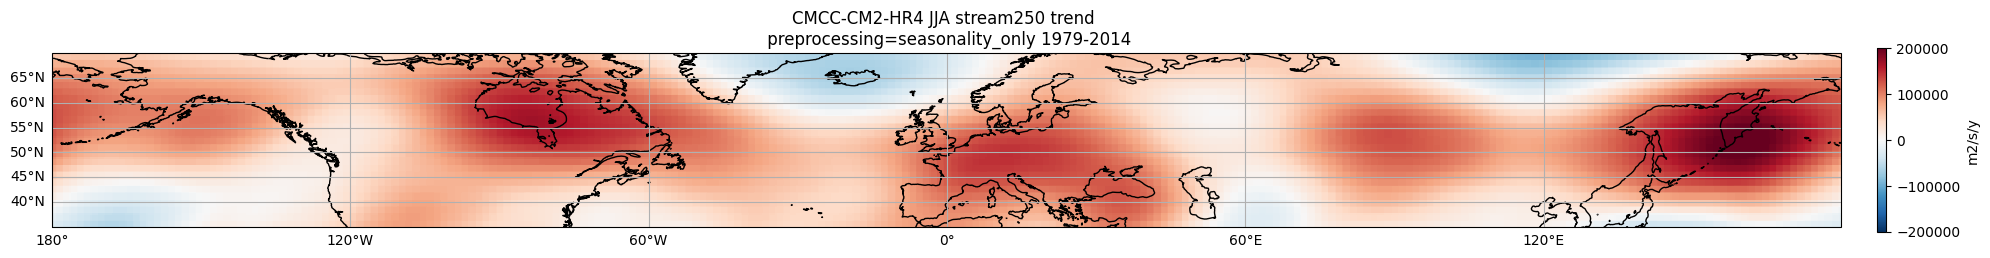

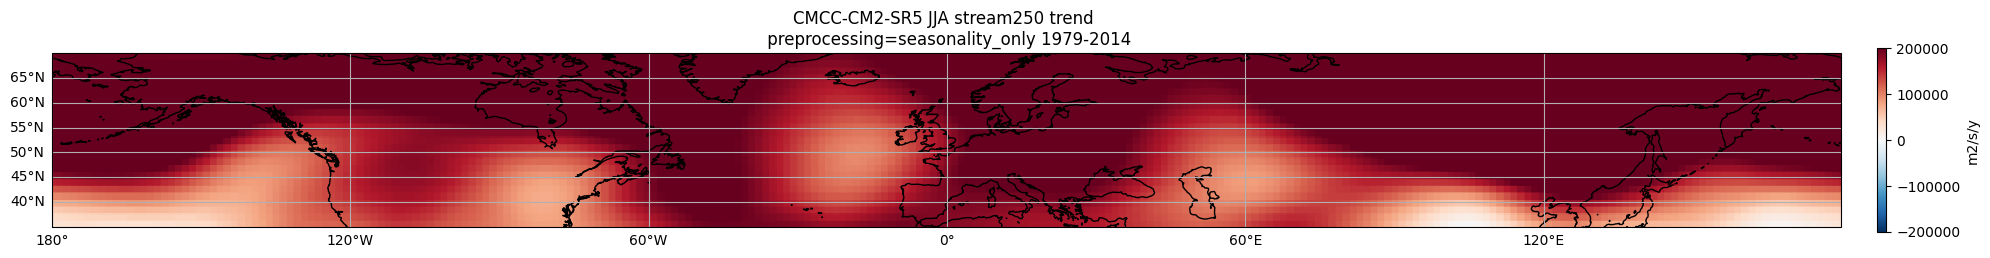

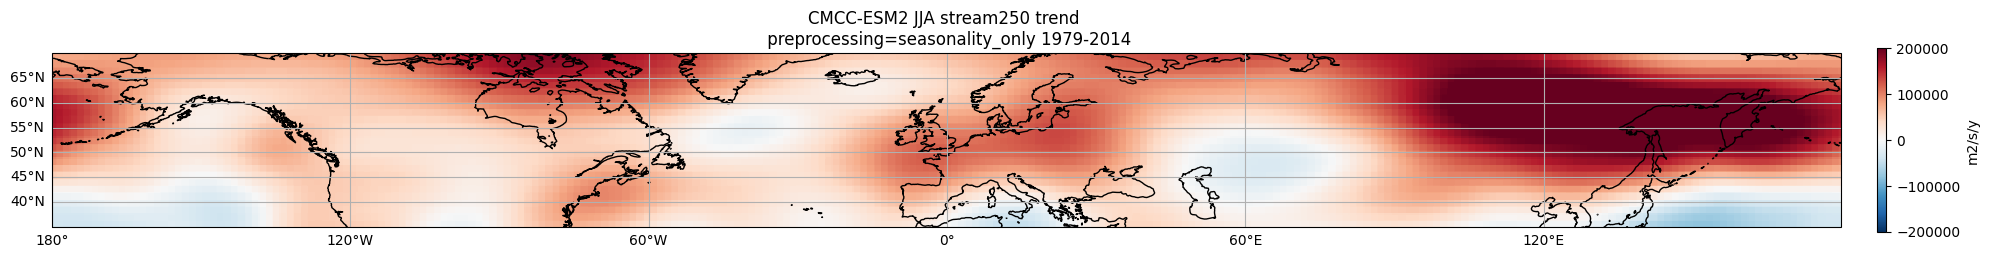

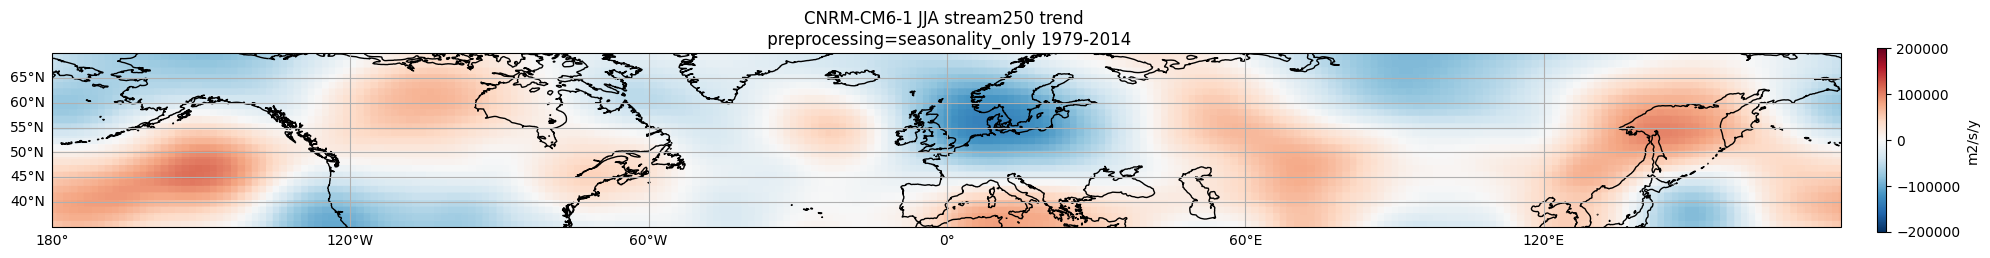

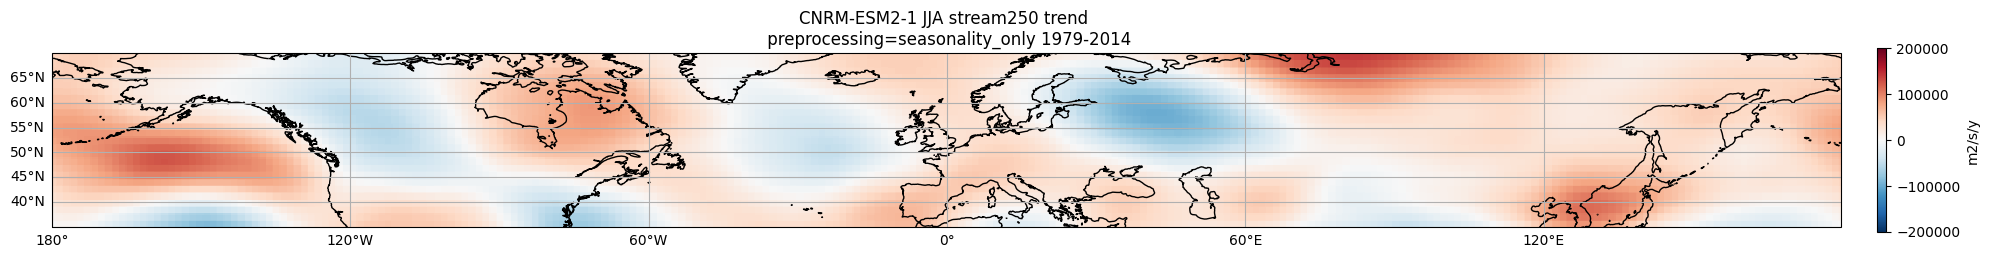

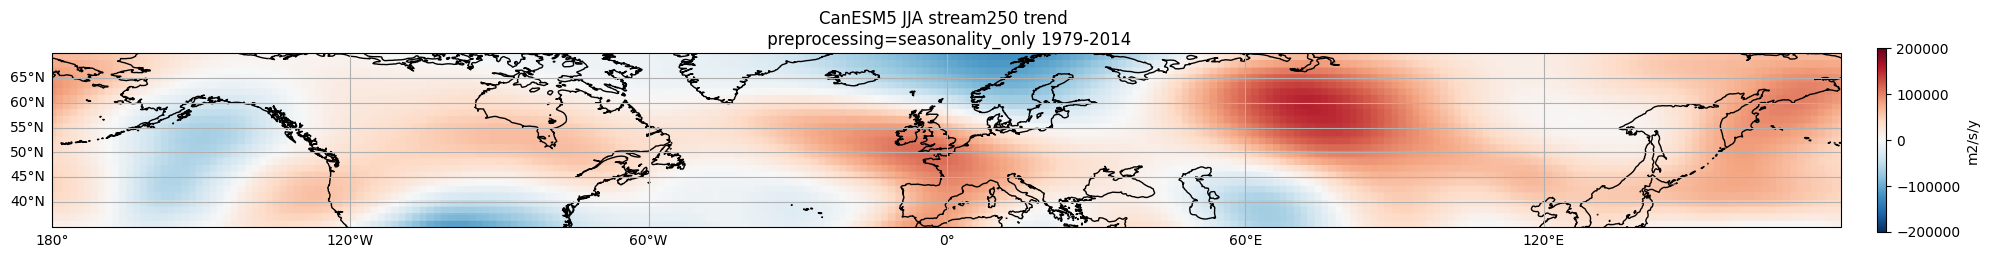

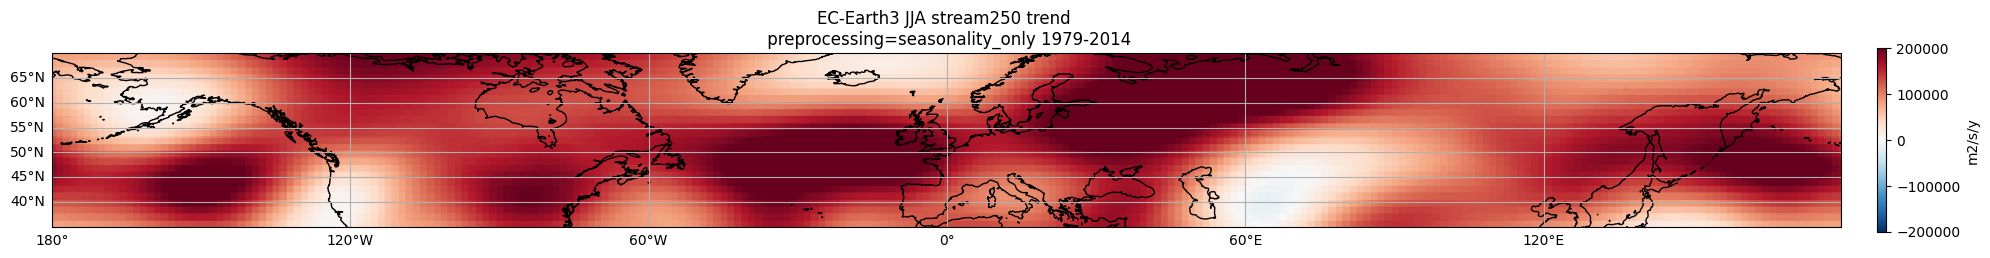

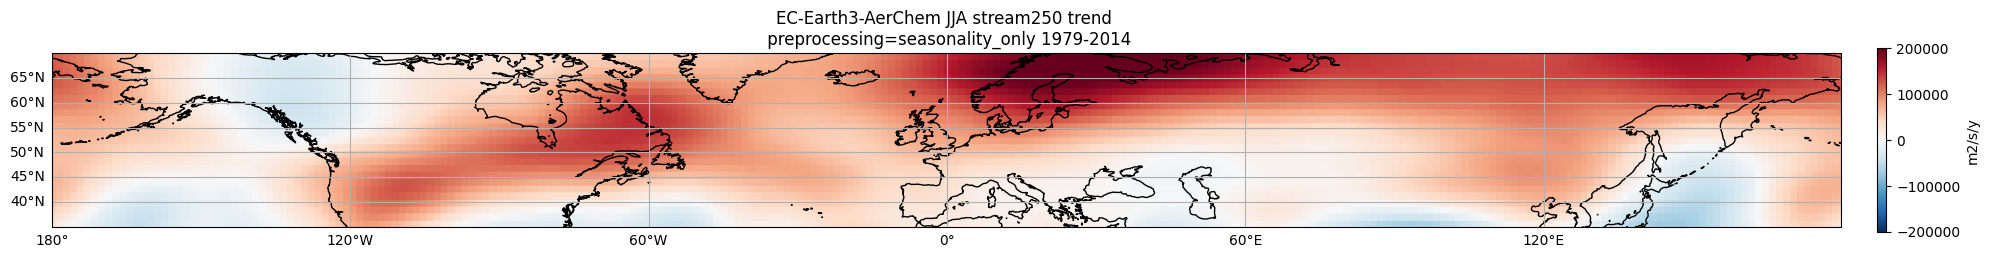

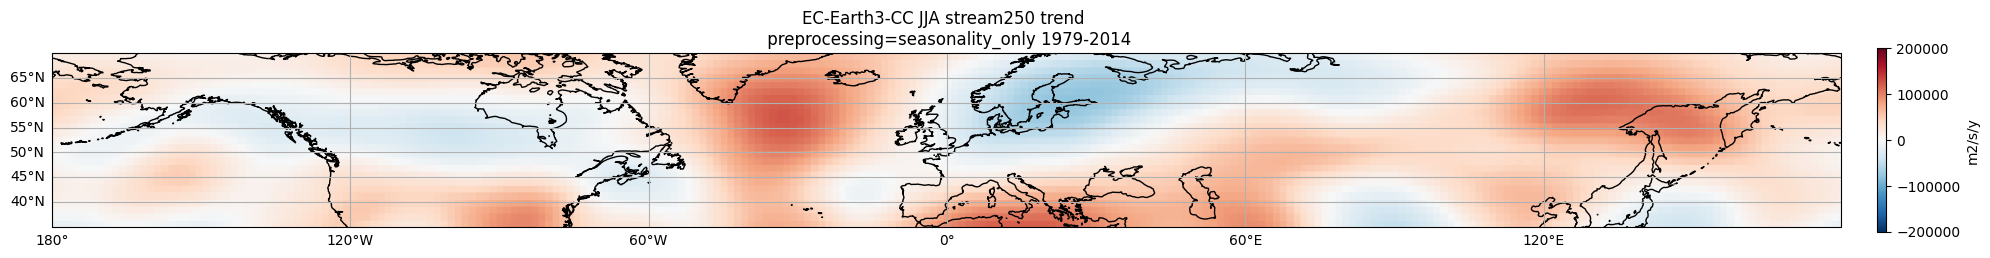

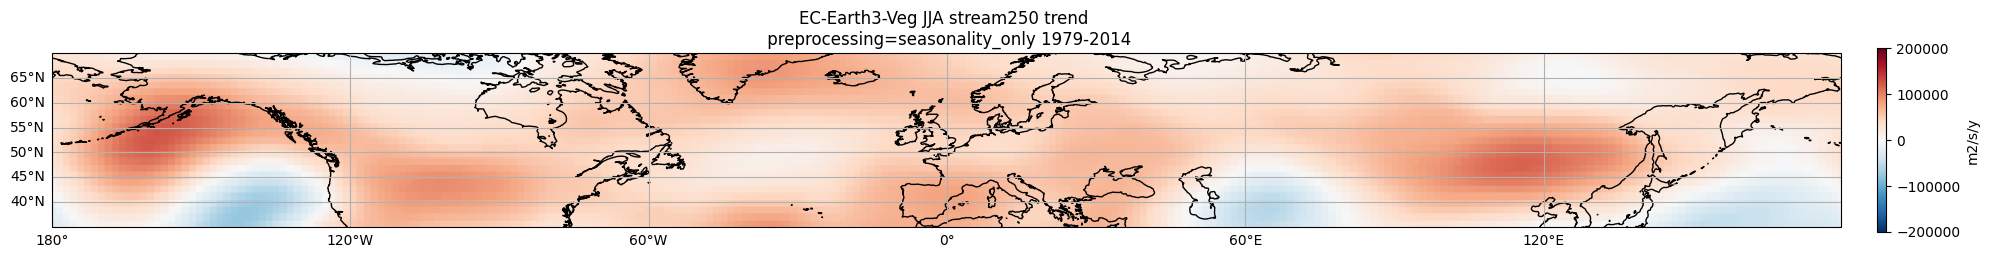

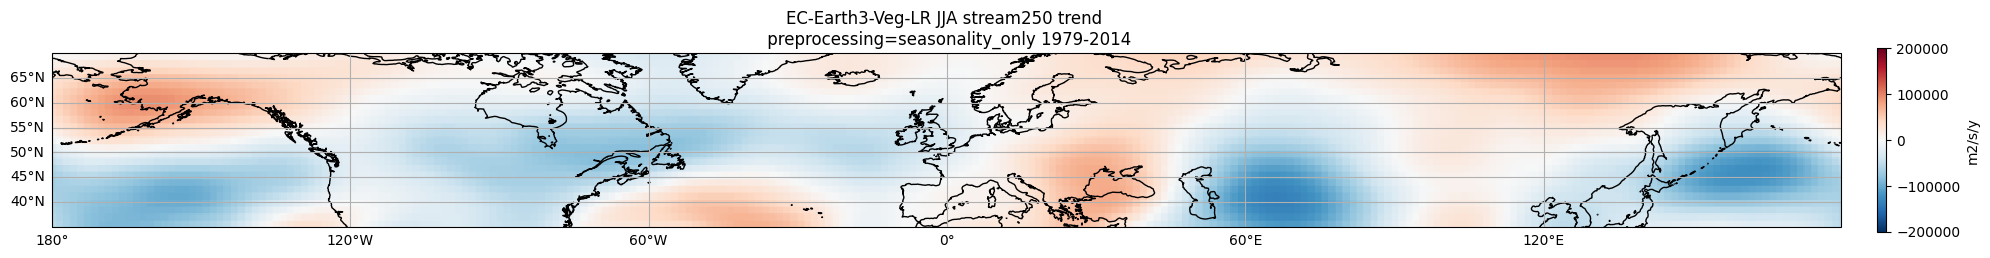

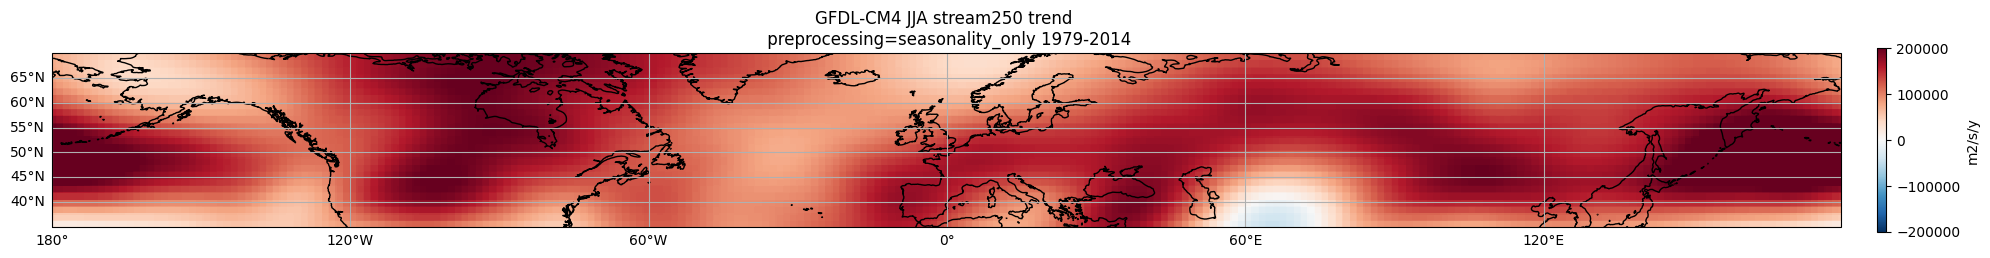

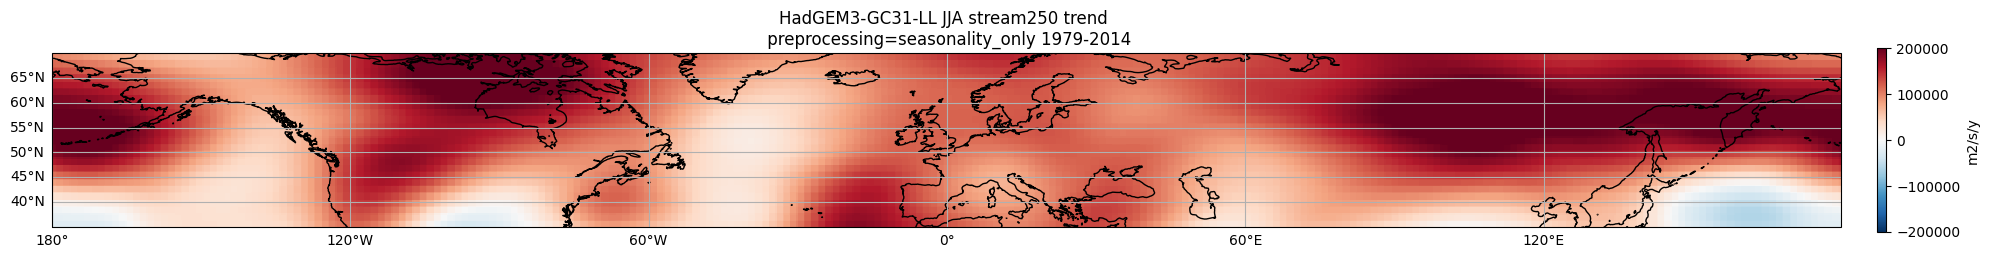

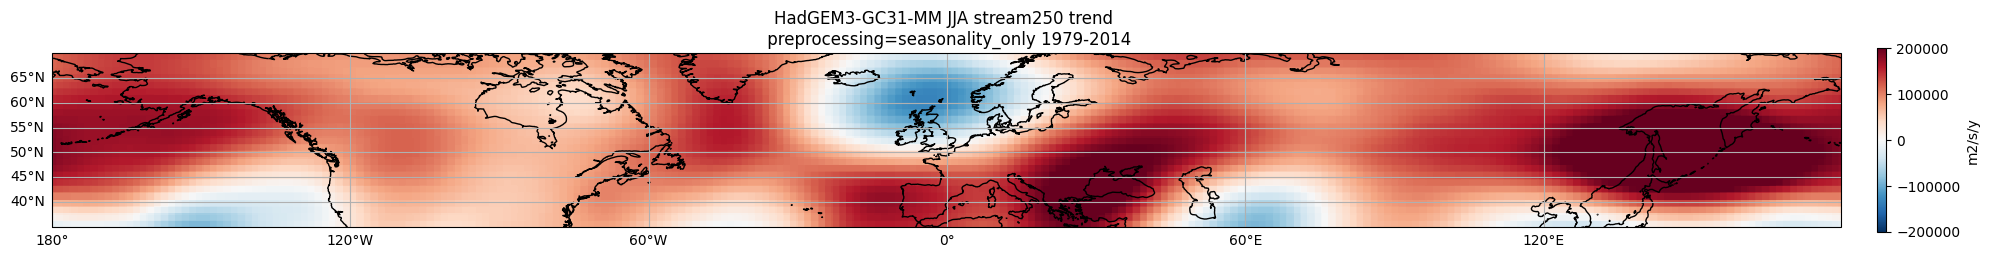

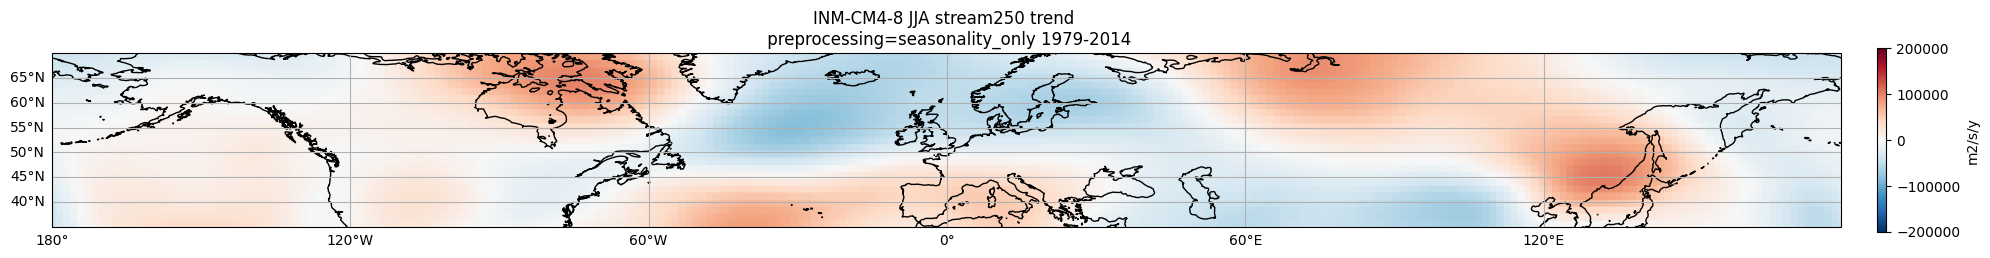

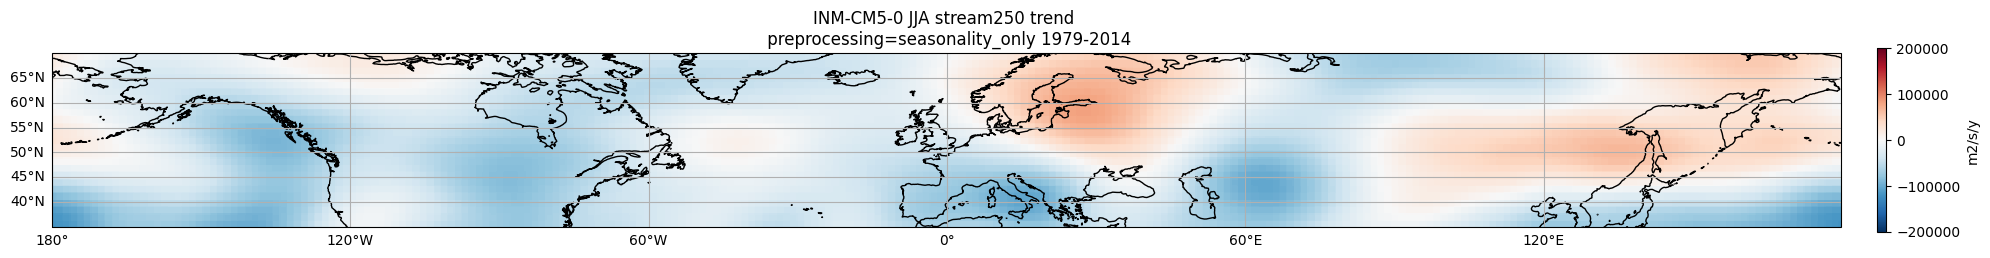

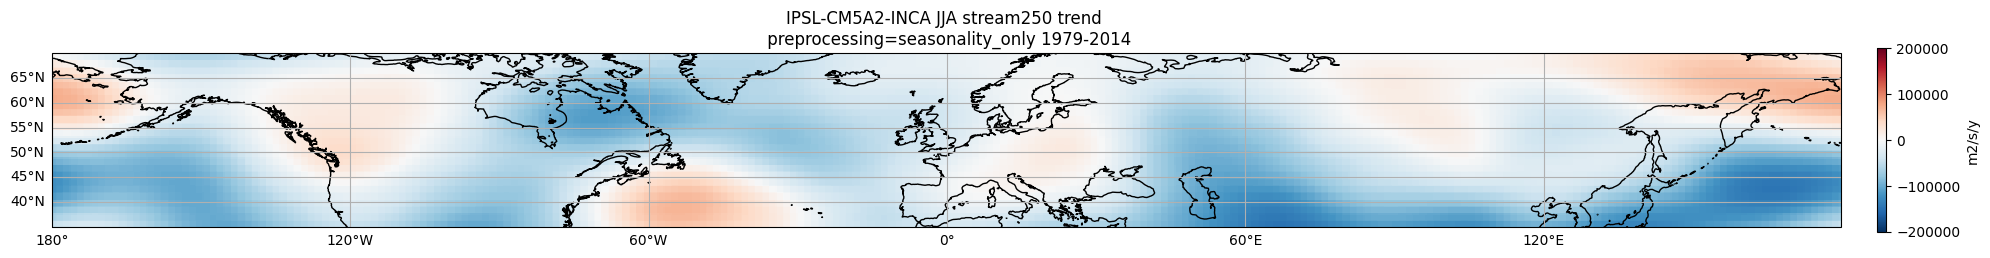

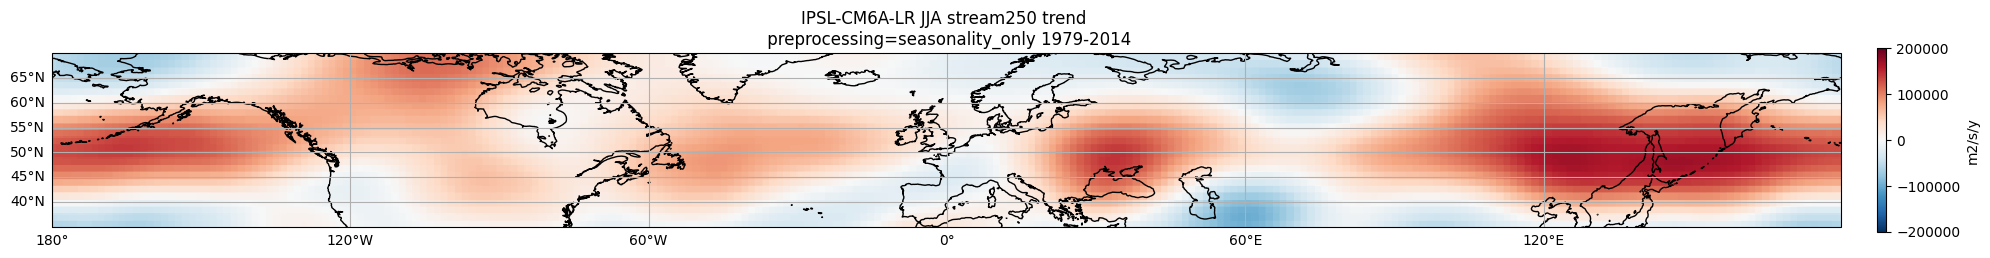

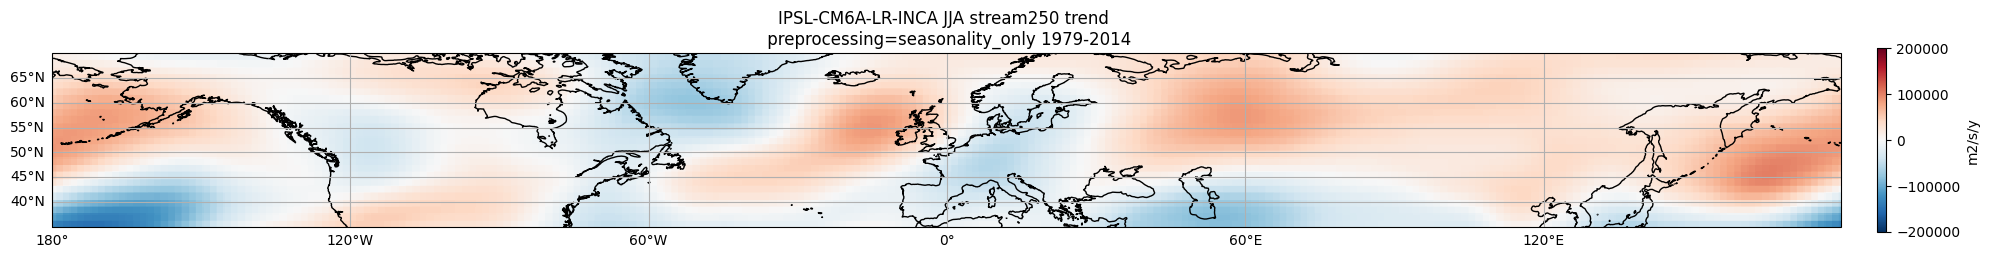

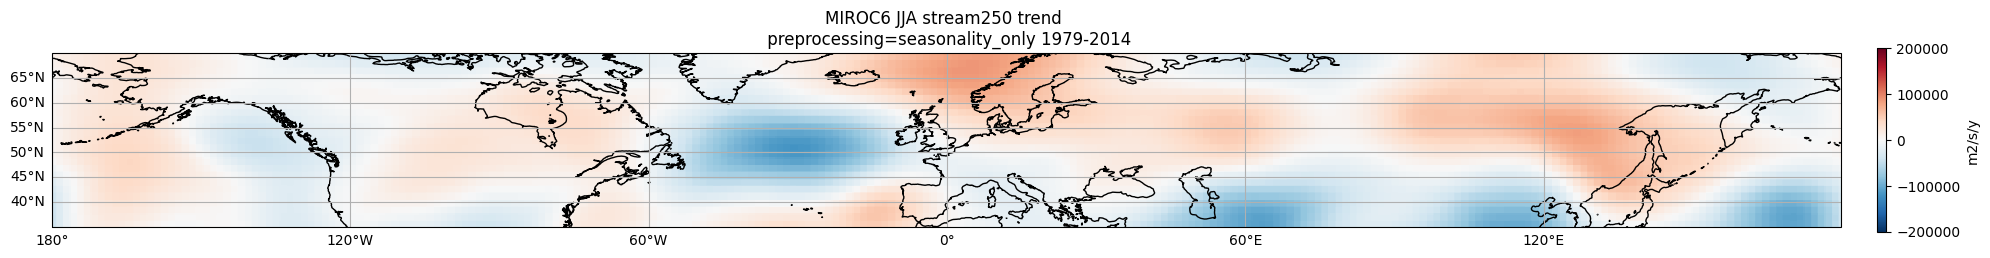

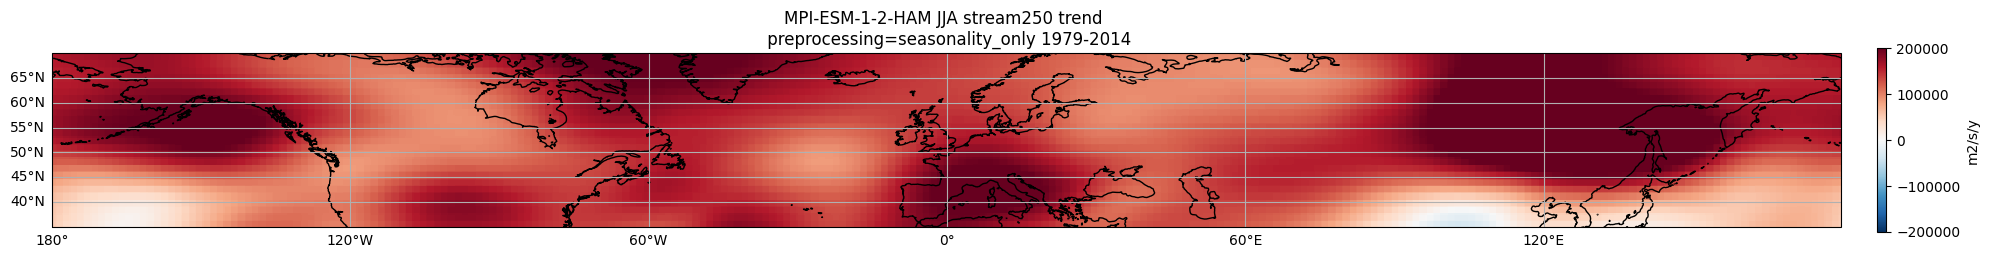

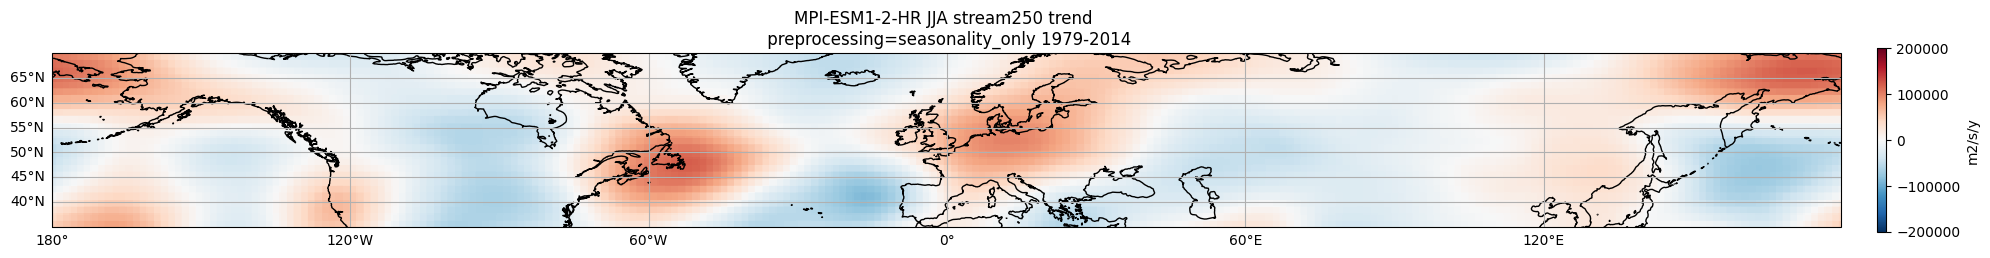

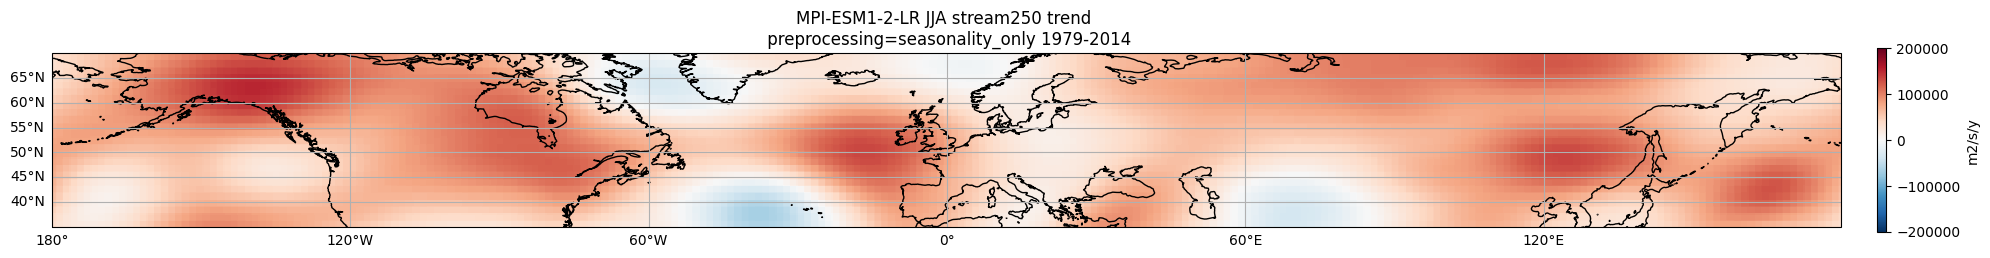

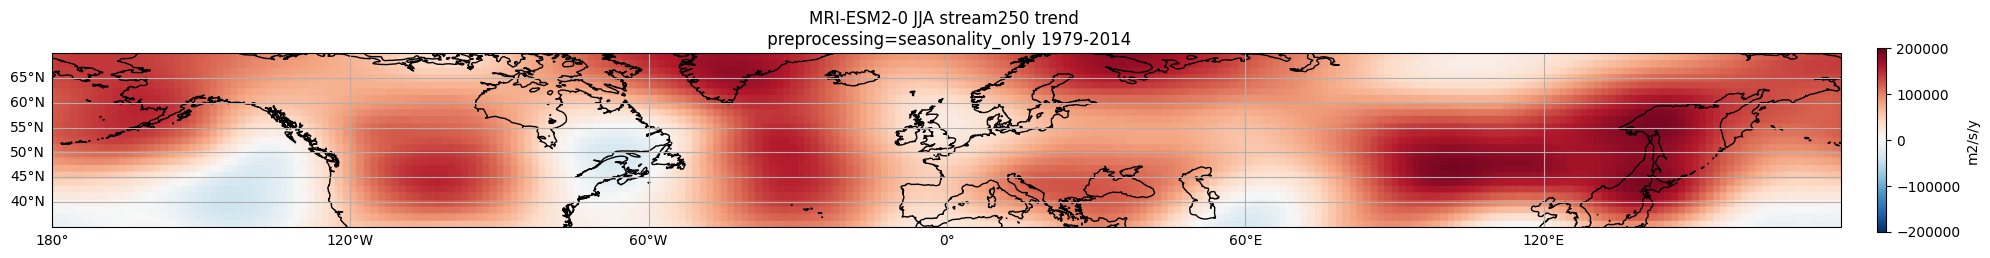

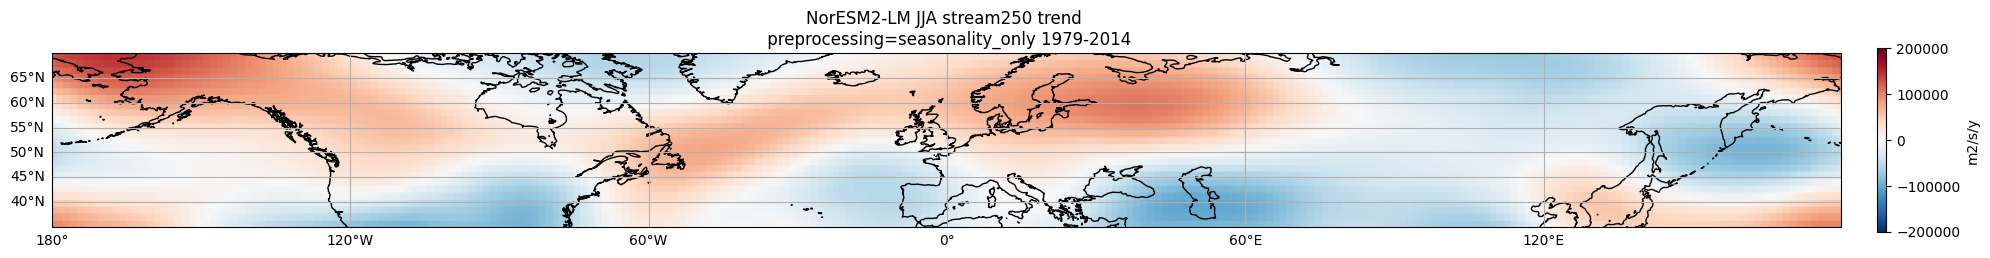

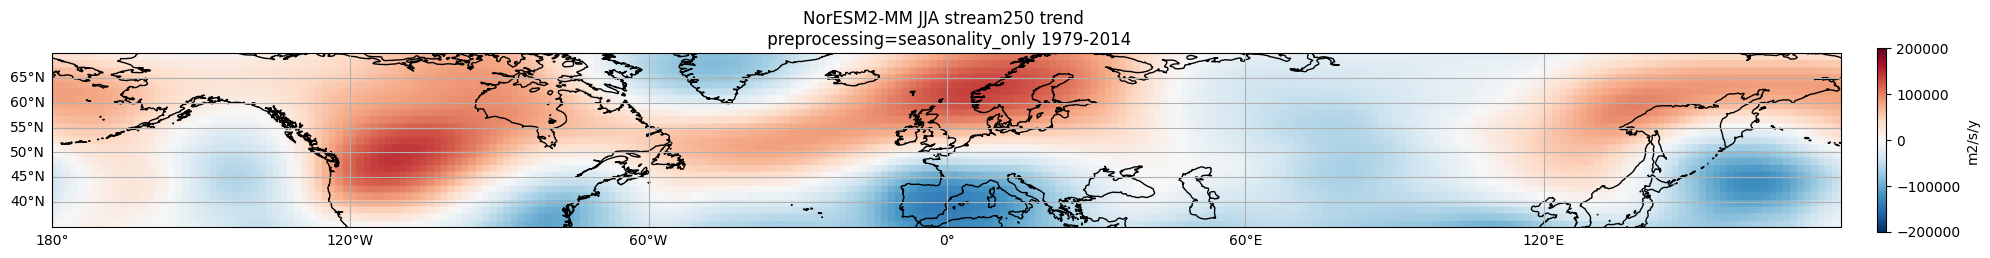

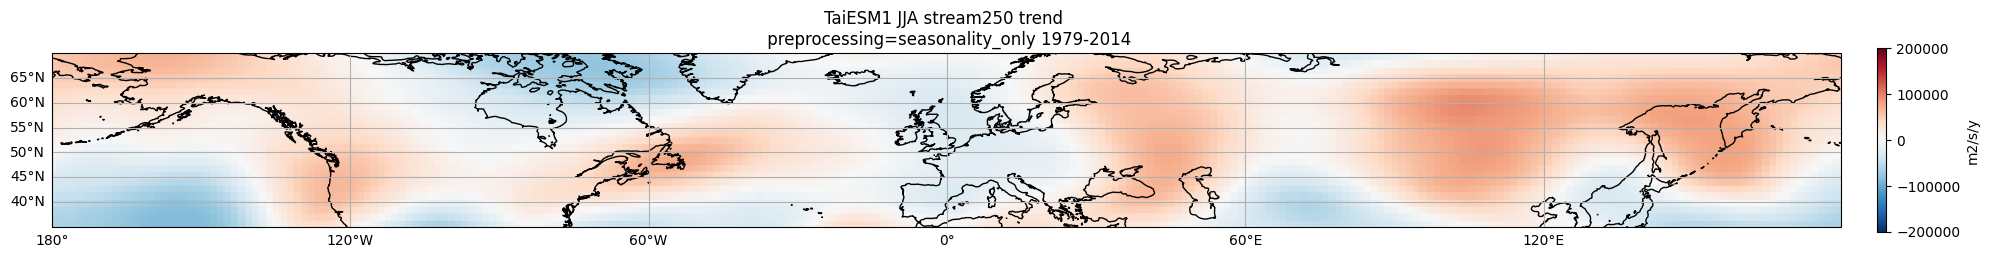

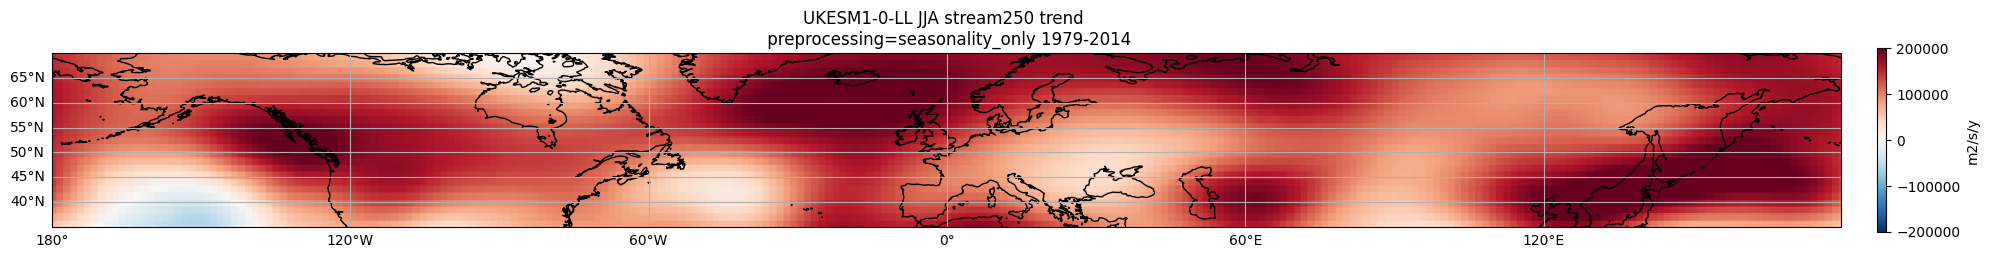

In [20]:
for i, model in enumerate(cmip6_names):
    print(model)
    CMIP6_trend, COVARS = get_stream_trend_pattern_CMIP6_plus_covar(model, daJJA_1979_2015_trend,
                                                                   lower_year = lower_year, 
                                                                    upper_year = upper_year)
    cmip6_covars_trend_nonmasked[model] = COVARS
    cmip6_trends[i]=CMIP6_trend

In [21]:
## To save the trend patterns
cmip6_trends_xr = xr.DataArray(data=cmip6_trends,
                         dims=["models", "latitude", "longitude"],
                         coords=dict(models=cmip6_names,
                                    latitude=CMIP6_trend.latitude,
                                    longitude=CMIP6_trend.longitude))

cmip6_trends_xr.to_netcdf(f"{path_data}/MultiModelMean_cmip6_stream250_trends_{lower_year}_{upper_year}.nc")

In [22]:
## To save the covars:

df = pd.DataFrame(cmip6_covars_trend_nonmasked)
df.to_csv(f"/scistor/ivm/the410/WAVE5/covars_cmip6_era5_stream250_{lower_year}_{upper_year}.csv")

## To load the covar data

In [10]:
cmip6_covars_trend_nonmasked = pd.read_csv(f"{HOME}/CirculationTrends_Happe2025JCLi/Data/covars_cmip6_era5_stream250_{lower_year}_{upper_year}.csv", 
                                           index_col=0).to_dict()

cmip6_covars_trend_nonmasked

{'ACCESS-CM2': {'circumglobal': 0.28975987,
  'Both': 0.53756607,
  'US_Atl': 0.24679278,
  'EURASIA': 0.7841849},
 'AWI-ESM-1-1-LR': {'circumglobal': -0.27020034,
  'Both': -0.52197546,
  'US_Atl': -0.6000406,
  'EURASIA': -0.58792686},
 'BCC-CSM2-MR': {'circumglobal': 0.29872233,
  'Both': 0.36402696,
  'US_Atl': 0.054672565,
  'EURASIA': 0.4795219},
 'CAMS-CSM1-0': {'circumglobal': -0.106812105,
  'Both': -0.20907035,
  'US_Atl': -0.07765403,
  'EURASIA': -0.40631995},
 'CESM2-WACCM': {'circumglobal': 0.23833191,
  'Both': 0.012919411,
  'US_Atl': 0.03546741,
  'EURASIA': 0.03740038},
 'CMCC-CM2-HR4': {'circumglobal': 0.25598353,
  'Both': 0.23993902,
  'US_Atl': 0.11962923,
  'EURASIA': 0.4865166},
 'CMCC-CM2-SR5': {'circumglobal': 0.30074605,
  'Both': 0.29106247,
  'US_Atl': 0.6854702,
  'EURASIA': -0.015767656},
 'CMCC-ESM2': {'circumglobal': 0.3980241,
  'Both': 0.24444693,
  'US_Atl': 0.2870919,
  'EURASIA': 0.21749915},
 'CNRM-CM6-1': {'circumglobal': -0.03967778,
  'Both': -

## plotting Figure 7A

In [11]:
##  GETTING THE CORRECT COLORS AND MARKERS 
models_ssts_only = ['MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'GFDL-CM4',
 'EC-Earth3-Veg-LR',
 'EC-Earth3-Veg',
 'EC-Earth3',
 'CanESM5',
 'CNRM-ESM2-1',
 'CNRM-CM6-1',
 'CMCC-CM2-SR5',
 'CESM2-WACCM',
 'BCC-CSM2-MR',
 'AWI-ESM-1-1-LR',
 'ACCESS-CM2']

models_stream_extra = cmip6_names = [
 'CAMS-CSM1-0',
 'CMCC-CM2-HR4',
 'CMCC-ESM2',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'IPSL-CM6A-LR-INCA',
 'TaiESM1',
 'UKESM1-0-LL']

## GETTING SOME COLORS AND MARKERS FOR THE PLOTTING 

from matplotlib import colormaps
colors = []
for i in np.arange(0,1,1/19):
    colors.append(colormaps.get_cmap('tab20')(i))

markers = {'.': 'point',
 'o': 'circle',
 'v': 'triangle_down',
 '^': 'triangle_up',
 '<': 'triangle_left',
 '>': 'triangle_right',
 'x': 'tri_down',
 '1': ".",          
 '2': 'tri_up',
 '3': 'tri_left',
 '4': 'tri_right',
 '8': 'octagon',
 's': 'square',
 'p': 'pentagon',
 '*': 'star',
 'h': 'hexagon1',
 'H': 'hexagon2',
 '+': 'plus',
 'x': 'x',
 'D': 'diamond'}.keys()

extra_markers = [ ',', 'd', '|', '_', 'P', 'X', 0, 1,2,3,4,5, 6, 7, 9, 10, 11]

marker_dict = {}
color_dict = {}
for i, model in enumerate(models_ssts_only):
    #print(model, i)
    marker_dict[model]=list(markers)[i]
    color_dict[model]=colors[i]

for i, model in enumerate(models_stream_extra):
    #print(model, i)
    marker_dict[model]=extra_markers[i]
    color_dict[model]='grey'

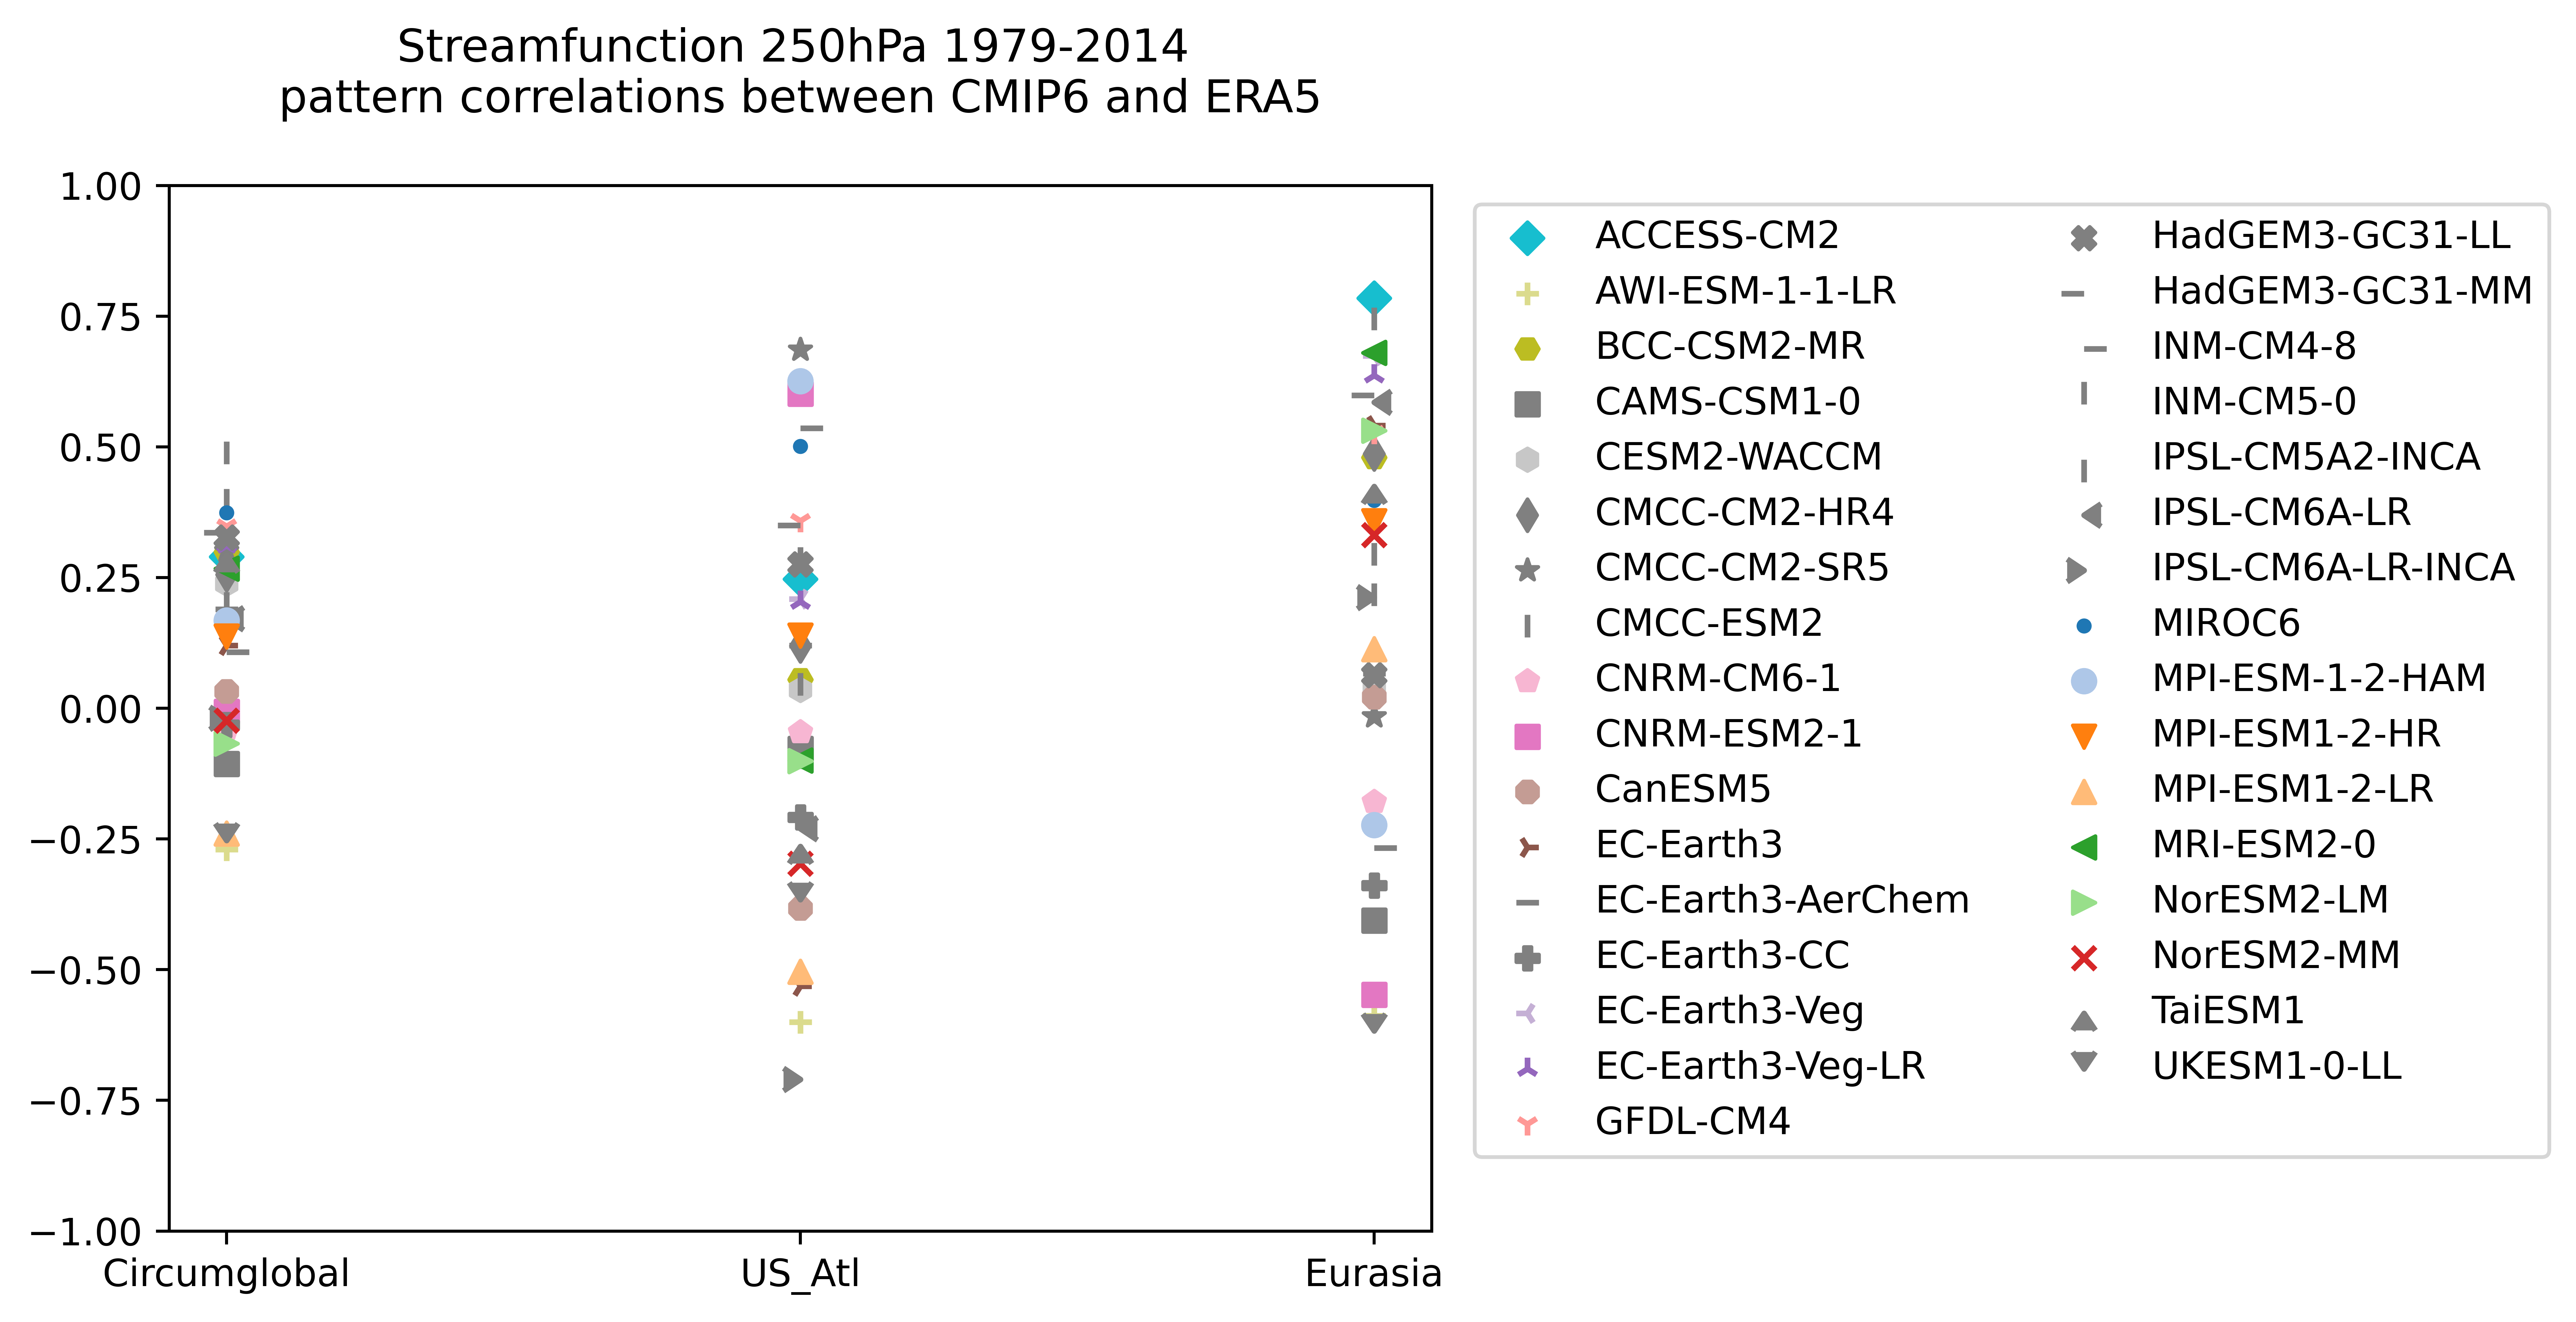

In [13]:
## HERE get covariance plots 
for model, items in cmip6_covars_trend_nonmasked.items():
    #print(model,items)
    plt.scatter("Circumglobal", items["circumglobal"], c=color_dict[model], marker=marker_dict[model])
    #plt.scatter("US_Atl & Eurasia", items["Both"], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("US_Atl", items["US_Atl"], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Eurasia", items["EURASIA"], c=color_dict[model], marker=marker_dict[model], label=model)
    
plt.legend(loc="upper right", bbox_to_anchor=(1.9,1), ncol=2)
plt.ylim(-1, 1)
plt.title(f"Streamfunction 250hPa {lower_year}-{upper_year} \n pattern correlations between CMIP6 and ERA5 \n ") #" LatWeight=True, Sign_masked=False")
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["figure.dpi"]=900

plt.savefig("/scistor/ivm/the410/GolfVijf/figures_revised/Fig7A_HQ.png", dpi=300)

